In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Set parameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCHS = 8  # Tambah epochs untuk train lebih lama
CHANNELS = 3
N_CLASSES = 5

In [3]:
# Normalisasi dataset (normalisasi ke rentang 0-1)
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


In [4]:
# Load dataset
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Simpan nama kelas
class_names = raw_train_ds.class_names

# Prefetch data
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
).map(normalize_img).prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/valid",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
).map(normalize_img).prefetch(buffer_size=AUTOTUNE)

# Pastikan test_ds tidak dimodifikasi (normalisasi tetap boleh)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/test",
    seed=123,
    shuffle=False,  # Jangan shuffle untuk evaluasi yang konsisten
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
).map(normalize_img).prefetch(buffer_size=AUTOTUNE)

Found 986 files belonging to 5 classes.
Found 986 files belonging to 5 classes.
Found 201 files belonging to 5 classes.
Found 132 files belonging to 5 classes.


In [5]:
# Prefetch data
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [6]:
# Load MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
)

# Freeze base model
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),  # Tingkatkan jumlah unit
    layers.Dropout(0.5),  # Dropout lebih besar untuk regularisasi
    layers.Dense(N_CLASSES, activation='softmax')
])

In [7]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Tingkatkan learning rate awal
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [31]:
# Menampilkan summary model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,851,921 (26.14 MB)

 Trainable params: 2,253,253 (8.60 MB)

 Non-trainable params: 92,160 (360.00 KB)

 Optimizer params: 4,506,508 (17.19 MB)

In [8]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Fungsi scheduler untuk mengurangi learning rate berdasarkan epoch
def scheduler(epoch, lr):
    if epoch < 3:
        return lr  # Tetap sama di awal
    else:
        return float(lr * tf.math.exp(-0.1))  # Ubah hasil ke tipe float


In [9]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6)
stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

In [10]:
# Initial training (transfer learning)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[reduce_lr, stop_early, lr_scheduler]
)

# Fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 100  # Unfreeze 100 layer terakhir
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
fine_tuning_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[reduce_lr, stop_early]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/8
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 931ms/step - accuracy: 0.4129 - loss: 1.7257 - val_accuracy: 0.5274 - val_loss: 1.0534 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 2/8
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 645ms/step - accuracy: 0.6674 - loss: 0.8483 - val_accuracy: 0.6070 - val_loss: 0.8632 - learning_rate: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 3/8
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 634ms/step - accuracy: 0.7650 - loss: 0.6239 - val_accuracy: 0.6816 - val_loss: 0.7502 - learning_rate: 5.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0004524187243077904.
Epoch 4/8
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 669ms/step - accuracy: 0.8134 - loss: 0.5135 - val_accuracy: 0.7612 - val_loss: 0.6796 - learning_rate: 4.5242e-04

Epoch 5: LearningRateScheduler setting learning rate to

In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - accuracy: 0.8585 - loss: 0.3949
Test Accuracy: 0.83


-------------------------------------------------------

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [14]:
# Ulangi Prediksi
test_labels = np.concatenate([y for x, y in test_ds], axis=0)  # Ambil label
pred_probs = model.predict(test_ds)  # Prediksi
pred_labels = np.argmax(pred_probs, axis=1)  # Prediksi kelas

# Report dan Visualisasi
report = classification_report(test_labels, pred_labels, target_names=class_names)
print("Classification Report:\n", report)


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step 
Classification Report:
                precision    recall  f1-score   support

  bercak-daun       0.77      0.82      0.80        40
   daun-sehat       1.00      1.00      1.00        40
   hawar-daun       0.71      0.88      0.79        17
   karat-daun       0.75      0.65      0.70        23
pengorok-daun       0.88      0.58      0.70        12

     accuracy                           0.83       132
    macro avg       0.82      0.79      0.80       132
 weighted avg       0.84      0.83      0.83       132



5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step


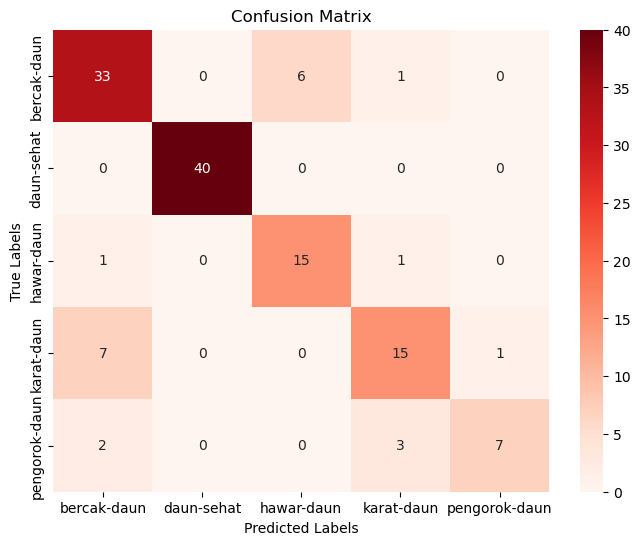

Classification Report:
                precision    recall  f1-score   support

  bercak-daun       0.77      0.82      0.80        40
   daun-sehat       1.00      1.00      1.00        40
   hawar-daun       0.71      0.88      0.79        17
   karat-daun       0.75      0.65      0.70        23
pengorok-daun       0.88      0.58      0.70        12

     accuracy                           0.83       132
    macro avg       0.82      0.79      0.80       132
 weighted avg       0.84      0.83      0.83       132



In [48]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Mendapatkan label aktual dan prediksi
test_labels = np.concatenate([y for x, y in test_ds], axis=0)  # Label asli
pred_probs = model.predict(test_ds)  # Probabilitas prediksi
pred_labels = np.argmax(pred_probs, axis=1)  # Prediksi kelas

# Buat confusion matrix
conf_matrix = confusion_matrix(test_labels, pred_labels)

# Visualisasi Confusion Matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, class_names)

# Menampilkan laporan klasifikasi
report = classification_report(test_labels, pred_labels, target_names=class_names)
print("Classification Report:\n", report)

# Plot grafik akurasi dan loss
def plot_training_history(history):
    # Grafik Akurasi
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='red')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


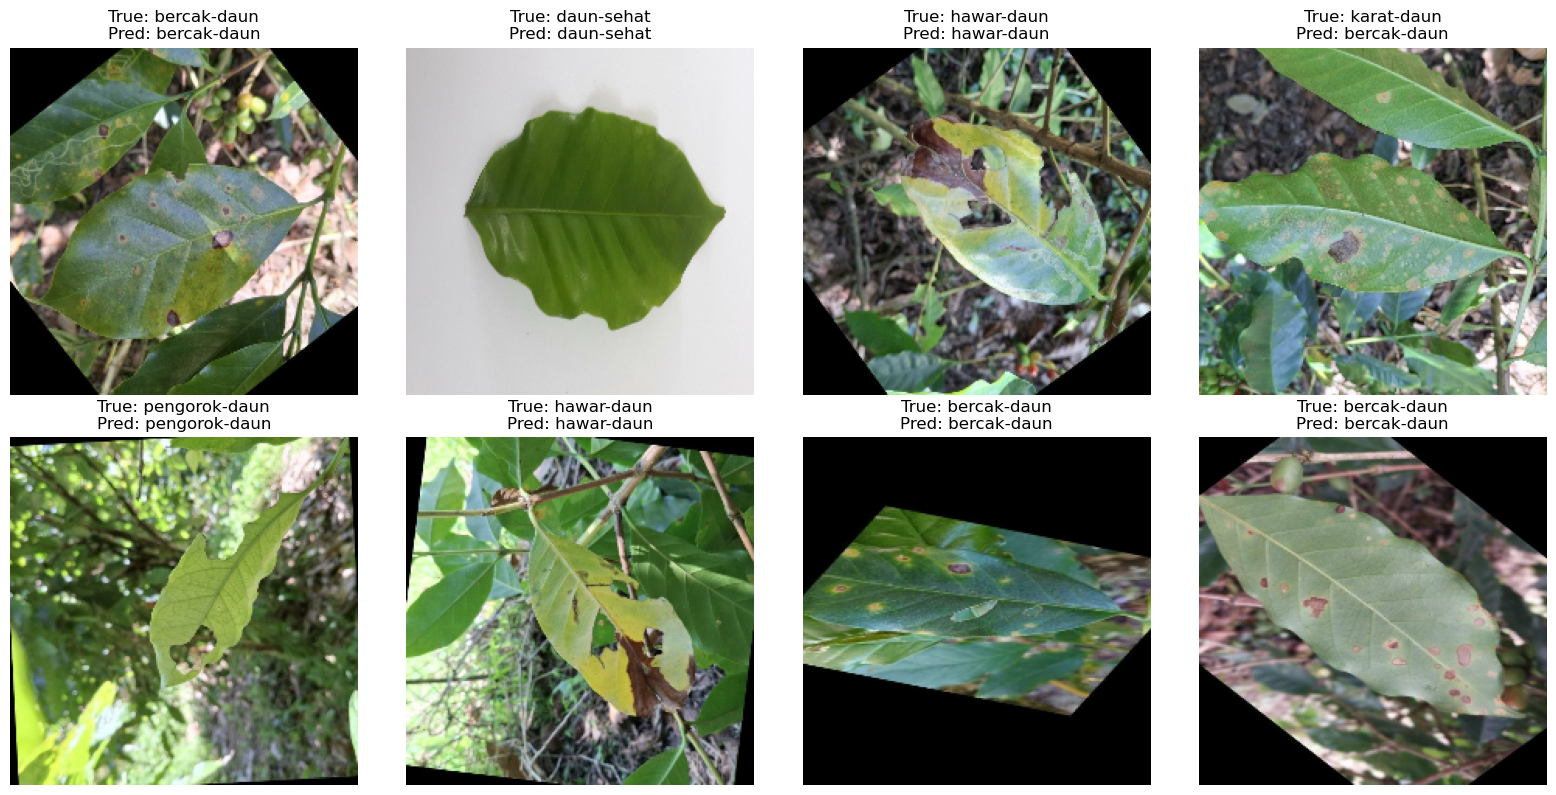

In [16]:

import random

def plot_predictions_with_fallback(dataset, model, class_names, n_images=8):
    """
    Menampilkan hingga n_images gambar, memastikan ada perwakilan gambar dari berbagai kelas.
    Jika jumlah kelas lebih sedikit dari n_images, gambar dari kelas yang sama akan ditampilkan.
    """
    plt.figure(figsize=(16, 8))
    displayed_classes = set()  # Menyimpan kelas yang sudah ditampilkan
    images_to_display = []  # Menyimpan gambar dan prediksi
    count = 0  # Counter untuk gambar yang ditampilkan

    # Iterasi dataset untuk mencari gambar dari berbagai kelas
    for images, labels in dataset.unbatch():
        true_label = class_names[labels.numpy()]
        if true_label not in displayed_classes:
            # Simpan gambar untuk ditampilkan
            pred_prob = model.predict(tf.expand_dims(images, axis=0))
            pred_label = class_names[np.argmax(pred_prob)]
            images_to_display.append((images.numpy(), true_label, pred_label))
            displayed_classes.add(true_label)
            count += 1
        if count >= n_images:
            break

    # Jika masih kurang dari n_images, tambahkan gambar acak
    if count < n_images:
        all_images = list(dataset.unbatch())
        random.shuffle(all_images)  # Acak dataset
        for images, labels in all_images:
            if count >= n_images:
                break
            true_label = class_names[labels.numpy()]
            pred_prob = model.predict(tf.expand_dims(images, axis=0))
            pred_label = class_names[np.argmax(pred_prob)]
            images_to_display.append((images.numpy(), true_label, pred_label))
            count += 1

    # Plot gambar
    for i, (img, true_label, pred_label) in enumerate(images_to_display):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Menampilkan hingga 8 gambar, memastikan perwakilan dari berbagai kelas
plot_predictions_with_fallback(test_ds, model, class_names, n_images=8)


In [17]:
# Simpan model MobileNetV2 dalam format .keras
model.save('./mobilenetv2_model.keras', save_format='keras')
print("Model MobileNetV2 berhasil disimpan")


Model MobileNetV2 berhasil disimpan
